# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test_submition.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

ex_users = df_users_ex["uid"].values
ix_ex = np.in1d(users, ex_users).reshape(users.shape)
X_ex_users = X_dataset[np.where(ix_ex)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train['cls'].values[np.where(ix)]
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])
print "Resulting submission set: (%dx%d) feature matrix" % (X_ex_users.shape[0], X_ex_users.shape[1])

Resulting training set: (6550x123424) feature matrix, 6550 target vector
Resulting submission set: (3922x123424) feature matrix


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

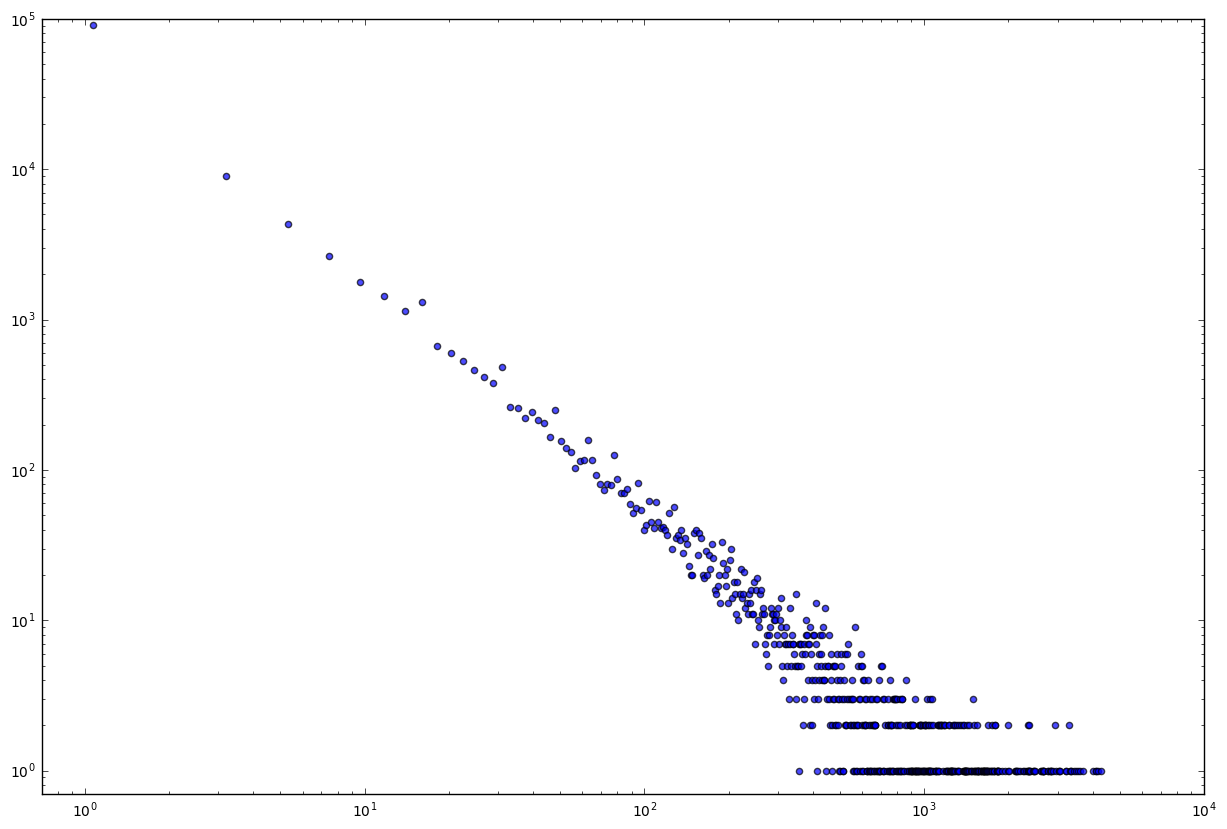

In [6]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    
    features_counts = np.array((x!=0).sum(axis=0)).flatten()
    bin_count = 2000
    y,x = np.histogram(features_counts,bins = np.linspace(0,features_counts.max(),num = bin_count))
    x = (x[:-1]+x[1:])/2
    #x,y = np.unique(features_counts,return_counts=True)
    pl.figure(figsize=(15,10))
    pl.scatter(x,y,alpha=0.7)
    pl.yscale('log')
    pl.xscale('log')
    pl.ylim(ymin=0.7)
    pl.xlim(xmin=0.7)
    
    
    return features_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [7]:
X1 = X.tocsc()[:, features_counts > 100].toarray()
X_ex_users = X_ex_users.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [8]:
USER_NAME = "v.guzov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [10]:
def sigmoid(z):
    return 1./(1+np.exp(-z))
class LogisticRegression():
    def __init__(self, lr = 0.1, reg_param=0.01, epoch_count = 10):
        self.reg_param = reg_param
        self.epoch_count = epoch_count
        self.lr = lr
    def fit(self, X, Y=None):
        def compute_cost(X, y, theta, lmbd): 
            def cost_func(X,y,theta):
                h = sigmoid(np.dot(X,theta))
                return -y*np.log(h)-(1-y)*np.log(1-h)
            J = np.sum(cost_func(X,y,theta))+lmbd*np.sum(np.abs(theta))
            return J
        def cost_function_gradient (X, y, theta, lmbd):
            h = sigmoid(np.dot(X,theta))
            gradient = np.dot((h-y),X)+np.sign(theta)*lmbd
            return gradient
        self.theta = np.zeros(X.shape[1])
        self.alpha = self.lr
        term_flag = False
        epoch_count = 0
        while not term_flag:
            for ind in np.random.permutation(X.shape[0]):
                X_samp = X[ind, :]
                Y_samp = Y[ind]
                grad = cost_function_gradient(X_samp,Y_samp,self.theta, self.reg_param)
                self.theta -= self.alpha*grad
            epoch_count += 1
            self.alpha = self.lr/(epoch_count+1)
            term_flag = (epoch_count>self.epoch_count)
        return self
    
    def predict_proba(self, X):
        probability = sigmoid(np.dot(X,self.theta))
        return np.vstack((1-probability, probability))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [11]:
def gen_roc(y_prob, y_true):
    step = 0.001
    tpr = []
    fpr = []
    pos_len = float(np.count_nonzero(y_true==1))
    neg_len = float(np.count_nonzero(y_true==0))
    for thr in np.arange(0.,1.,step):
        y_thr = (y_prob>thr).astype(np.int)
        tpr.append(np.count_nonzero(np.logical_and(y_thr==1,y_true==1))/pos_len)
        fpr.append(np.count_nonzero(np.logical_and(y_thr==1,y_true==0))/neg_len)
    return np.array(fpr+[0]), np.array(tpr+[0])
def auroc(y_prob, y_true):
    fpr, tpr = gen_roc(y_prob, y_true)
    sort_ind = np.argsort(fpr)
    fpr = fpr[sort_ind]
    tpr = tpr[sort_ind]
    auc=tpr[0]/2*fpr[0]+tpr[0]*(fpr[1]-fpr[0])/2.+tpr[-1]*(1-(fpr[-1]+fpr[-2])/2.)
    for i in xrange(1,len(fpr)-1):
        auc+=tpr[i]*(fpr[i+1]-fpr[i-1])/2.
    return auc

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [86]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
n_folds = 5
def select_reg_parameter(C, X, Y):
    kfold = cv.KFold(X.shape[0], n_folds=n_folds, shuffle=True)
    max_sum = 0
    best_c_ind = 0
    for c_ind, c in enumerate(C):
        sum_score = 0
        for train_ind, test_ind in kfold:
            reg = LogisticRegression(reg_param = c).fit(X[train_ind,:],Y[train_ind])
            auc = auroc(reg.predict_proba(X[test_ind,:])[1], Y[test_ind])
            sum_score+=sm.roc_auc_score(Y[test_ind], reg.predict_proba(X[test_ind,:])[1])
        if max_sum<sum_score:
            max_sum = sum_score
            best_c_ind = c_ind
        print "%d) C = %.2f, mean AUC = %.4f" %(c_ind,c,sum_score/n_folds)
    return best_c_ind

index = select_reg_parameter(C, X1, Y)
print "Best is %d, C = %.2f"%(index,C[index])


0) C = 0.00, mean AUC = 0.5123
1) C = 0.01, mean AUC = 0.5130
2) C = 0.10, mean AUC = 0.5003
3) C = 1.00, mean AUC = 0.4997
4) C = 10.00, mean AUC = 0.5024
5) C = 100.00, mean AUC = 0.4953
6) C = 1000.00, mean AUC = 0.5063
7) C = 10000.00, mean AUC = 0.4974
Best is 1, C = 0.01


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.524700


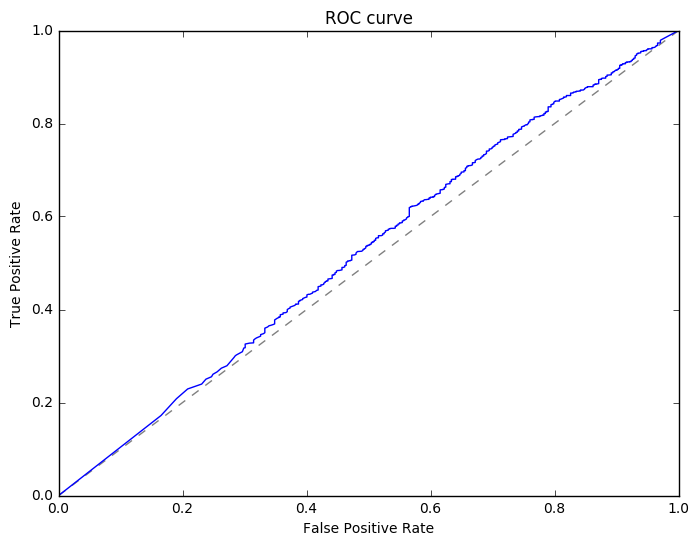

In [85]:
def classify(X, Y, test_size, c):
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=test_size)
    reg = LogisticRegression(reg_param = c, lr=0.01, epoch_count=100).fit(X_train,Y_train)
    Y_prob = reg.predict_proba(X_test)[1]
    fpr,tpr = gen_roc(Y_prob,Y_test)
    roc_auc = auroc(Y_prob,Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    pl.figure(figsize=(8,6))
    pl.title('ROC curve')
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.plot([0, 1], [0, 1], '--',color='gray')
    pl.plot(fpr,tpr,color = 'blue')

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [12]:
reg = LogisticRegression(reg_param = 0.01, lr=0.01, epoch_count=100).fit(X1,Y)
Y_ex = reg.predict_proba(X_ex_users)[1]
df_users_ex['cls'] = 0
df_users_ex.loc[df_users_ex['uid'].isin(data['users'][ix_ex]),'cls'] = Y_ex
df_users_ex.to_csv("submission.csv", index=False)